In [7]:
%%capture output
%run "3. Feature Engineering, Extraction and Selection.ipynb"
print('Operation complete')

# Model Selection and Evaluation

## Importing dependencies

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV

#models
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Modeling

### Model Selection

After creating the classification model objects, I will proceed by performing a k=10 cross-validation

In [9]:
# creating the objects
NB = GaussianNB()
MNB = MultinomialNB()
LR = LogisticRegression(random_state=0)
SV = SVC()
DT = DecisionTreeClassifier()
RF = RandomForestClassifier(random_state=0)
XGB = xgb.XGBClassifier(random_state=0)
KNN = KNeighborsClassifier()
# model.get_params()

### Which model should i pick?

To have a really general idea on our models let's run our models firstly on all the data, then on the train and test sets respectively.

In [10]:
X = tfidf.fit_transform(data['Clean Review']).toarray()
y = data['Target']

crossval_dict = {0: 'Naive Bayes', 
                1: 'Multinomial Naive Bayes',
                2: 'Logistic Regression',
                3: 'SVC',
                4: 'Decision Tree',
                5: 'Random Forest',
                6: 'XGBoost',
                7: 'KNN'}
crossval_models=[NB, MNB, LR, SV, DT, RF, XGB, KNN]

# iterate over all the models computing the general accuracy on all the data
for i, model in enumerate(crossval_models):
    print("{} Trial Accuracy: {}".format(crossval_dict[i], cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Naive Bayes Trial Accuracy: 0.854054054054054
Multinomial Naive Bayes Trial Accuracy: 0.8689189189189189
Logistic Regression Trial Accuracy: 0.8756756756756758
SVC Trial Accuracy: 0.8729729729729729
Decision Tree Trial Accuracy: 0.845945945945946
Random Forest Trial Accuracy: 0.8770270270270271
XGBoost Trial Accuracy: 0.8891891891891893
KNN Trial Accuracy: 0.895945945945946


Cross_val_score is a function from scikit-learn that outputs the average accuracy by performing cross-validation: it splits the data into multiple folds and evaluates the model's performance on each fold, in this case 10 folds. 

Now looking at the results, we notice that all the accuracies are between 80% and 90%. Therefore it is necessary to compare the models from different points of view. Let's take a look at more specific metrics for classification tasks such as precision and F1 for each non optimized model.

In [11]:
print('------------------TRAIN SET------------------')
results = []
for i, model in enumerate(crossval_models):
    # train the models
    model.fit(X_train, y_train)

    # compute metrics and append them to the results list
    accuracy = model.score(X_train, y_train)
    precision = precision_score(y_train, model.predict(X_train), average="micro")
    f1 = f1_score(y_train, model.predict(X_train), average="weighted")
    results.append({'Model': crossval_dict[i], 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

df_results = pd.DataFrame(results)
df_results

------------------TRAIN SET------------------


,Model,Accuracy,Precision,F1
0,Naive Bayes,0.997050,0.997050,0.997050
1,Multinomial Naive Bayes,0.990413,0.990413,0.990377
2,Logistic Regression,1.000000,1.000000,1.000000
3,SVC,1.000000,1.000000,1.000000
4,Decision Tree,1.000000,1.000000,1.000000
5,Random Forest,1.000000,1.000000,1.000000
6,XGBoost,1.000000,1.000000,1.000000
7,KNN,0.689528,0.689528,0.585650


The F1 suggests that the KNN, which was the best in the previous output, is now the worst model. Seems like the models are generally overfitting the training data. To show an example of overfitting in this case we will use the decision tree.

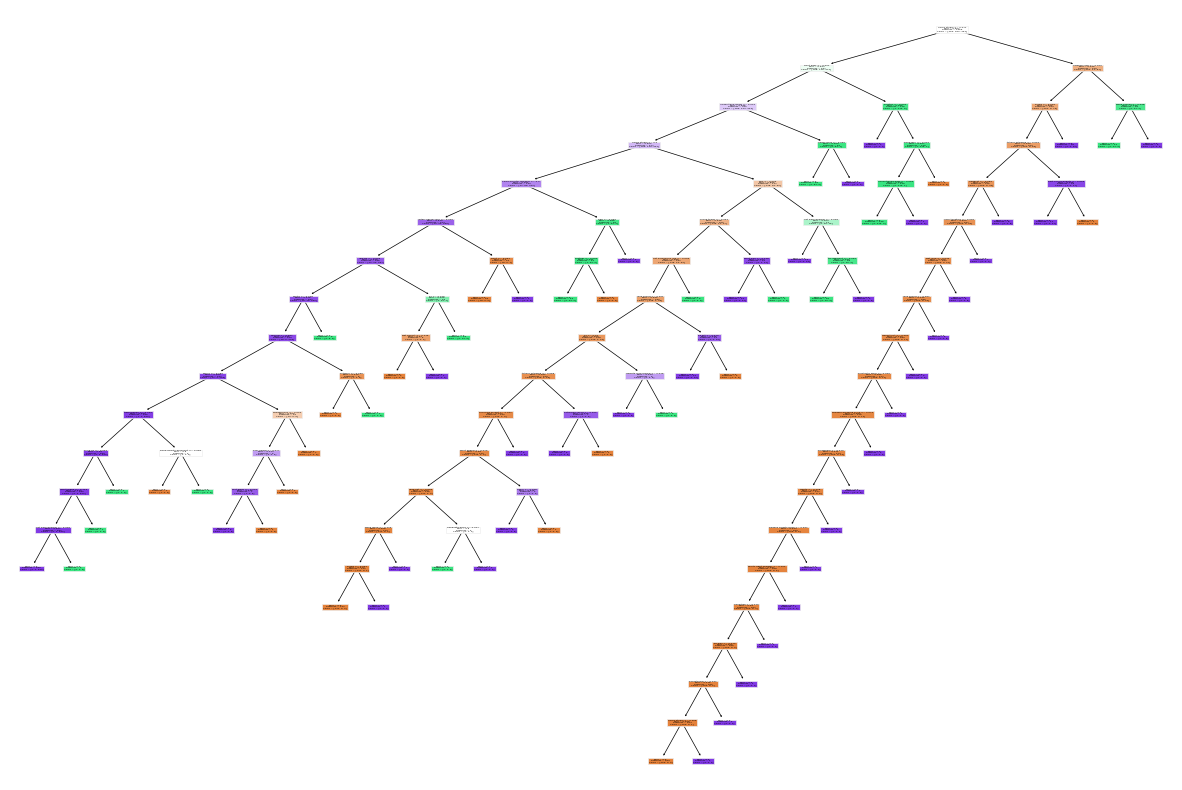

In [12]:
plt.figure(figsize=(15,10))
plot_tree(decision_tree=DT, feature_names=tfidf.get_feature_names(), filled=True)
plt.show()

In the leaves we probably have just single observations/reviews. We need a more generalized tree.

### Hyperparameter tuning

Let's apply different random configurations to see how to model's accuracy changes in train and test sets. We need to pay attention to how the accuracies are similar when we reduce the model's complexity. We should pick up a good configuration based on the test accuracy.

For the hyperparameter tuning there are different approaches, but in this analysis I will use the Grid Search Optimization: it creates a grid-like structure with all possible combinations of the predefined set of hyperparameters and evaluates each combination using **cross-validation** (or a separate validation set), which will help to reduce the overfitting. Since in some case it takes too much time, I will implement a Randomized Search which works in the same way as the Grid Search but only on a random subset of the combinations.

We will do hyperparameter optimization on:
- Logistic Regression
- Random Forest
- SVC
- XGBoost

In [17]:
# defining a hyperparameter tuning function
def hypertuning(classifier, param_grid, metric='accuracy', verbose_value=1):
    cv_method = KFold(n_splits=5, shuffle=True)
    if classifier == LR or classifier == SV:
        model = GridSearchCV(
                estimator = classifier,
                param_grid = param_grid,
                scoring = metric,
                verbose = verbose_value,            # default to 1 since i don't want to see every otuput
                cv = cv_method)                     # 5 folds
    else:
        model = RandomizedSearchCV(
                estimator = classifier,
                param_distributions = param_grid,
                n_iter = 5, 
                scoring = metric,
                n_jobs = 4, 
                cv = cv_method, 
                verbose = verbose_value, 
                random_state = 1001)
        
    # then fit the new fine-tuned model and get the best score and hyperparams set
    model.fit(X_train ,y_train)
    print(f"Best Score: {model.best_score_}")       # best_score_ is the average of all cv folds for a single combination of the parameters
    print("Best hyperparameter set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")
    print(f"Accuracy of classifier on test set: {model.score(X_test, y_test)}")

    # confusion matrix
    y_pred = model.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(confusion, classes=['Negative','Neutral','Positive'])
    return model, best_parameters

In [18]:
# defining a function to plot the 3x3 confusion matrix
def confusion_matrix_plot(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

For baseline purposes I will also run the metrics for the selected models on the test set after already trainign them.

#### Logistic Regression

In [19]:
# define the hyperparameter space
param_grid = {
    'penalty': ["l1","l2"],
    'C': [0.01, 0.1, 1, 10],
    'tol': [0.0001, 0.001, 0.01],  
    'max_iter': [100, 100]
}

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Score: 0.995574668981984
Best hyperparameter set:
	C: 10
	max_iter: 100
	penalty: l2
	tol: 0.0001
Accuracy of classifier on test set: 0.8963963963963963


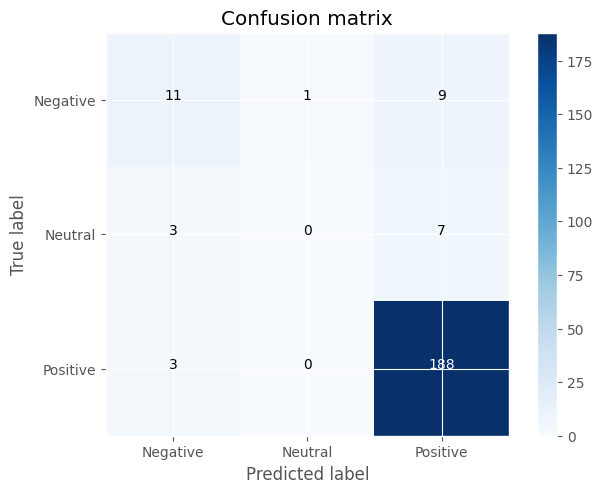

In [20]:
logreg, best_param = hypertuning(classifier = LR, param_grid = param_grid)

#### Random Forest

In [21]:
# define the hyperparameter space
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 25, 30, 40, 50, 60, 70, 80],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 5, 7, 10],
    'n_estimators': [200, 400, 600, 800, 1000],
    
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.9859887128283047
Best hyperparameter set:
	bootstrap: True
	max_depth: 80
	min_samples_leaf: 1
	min_samples_split: 5
	n_estimators: 200
Accuracy of classifier on test set: 0.8783783783783784


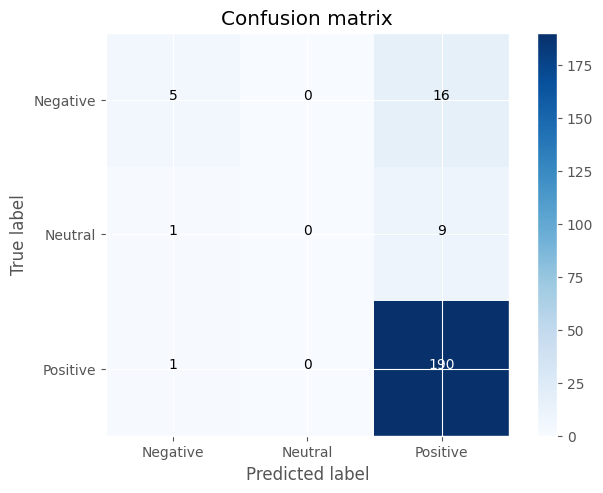

In [22]:
randfor, best_param = hypertuning(classifier = RF, param_grid = param_grid)

#### Support Vector Machine Classifier

In [23]:
# define the hyperparameter space
param_grid = {
    'C': [0.1, 1, 10],                                  
    'kernel': ['linear', 'rbf', 'sigmoid']
}

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Score: 1.0
Best hyperparameter set:
	C: 1
	kernel: rbf
Accuracy of classifier on test set: 0.8693693693693694


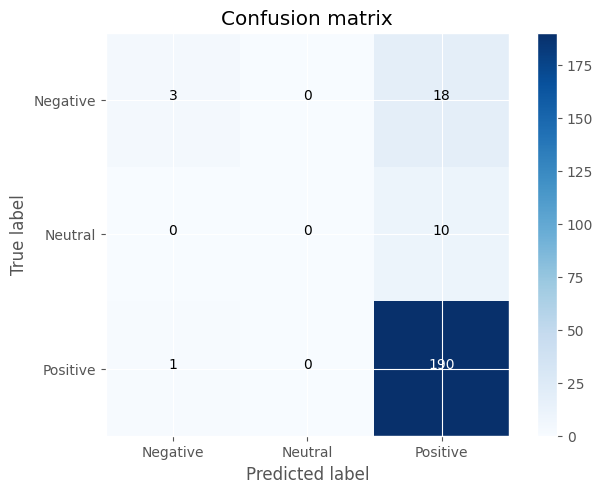

In [24]:
svc, best_param = hypertuning(classifier = SV, param_grid = param_grid)

On the main diagonal we can see the correctly classified reviews. As expected from the analysis of the sentences, reviews, whether they are negative, neutral or positive, tend to be classified as positive. But I would say this is pretty much normal, even after the SMOTE balancing, since the words in the reviews (with regard to their sentiment) are not that different.

#### XGBOOST

In [ ]:
# XGB.get_params()

In [25]:
# defining some of the hyperparameters
param_grid = {
        'max_depth': [3,5,7,9],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [100, 200],
        }

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.9756566095072715
Best hyperparameter set:
	colsample_bytree: 0.8
	gamma: 0.5
	max_depth: 3
	min_child_weight: 1
	n_estimators: 100
	subsample: 0.6
Accuracy of classifier on test set: 0.8873873873873874


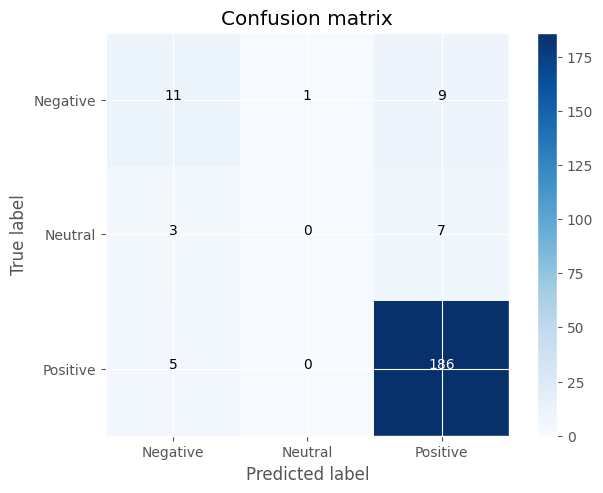

In [26]:
xg, best_param = hypertuning(classifier = XGB, param_grid = param_grid)

### Results

In [27]:
crossval_dict = {0: 'Logistic Regression',
                1: 'SVC',
                2: 'Random Forest',
                3: 'XGBoost'}
crossval_models=[LR, SV, RF, XGB]

In [28]:
results = []
for i, model in enumerate(crossval_models):
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, model.predict(X_test), average="micro")
    f1 = f1_score(y_test, model.predict(X_test), average="weighted")
    results.append({'Model': crossval_dict[i], 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})
df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,Precision,F1
0,Logistic Regression,0.900901,0.900901,0.882727
1,SVC,0.869369,0.869369,0.822060
2,Random Forest,0.873874,0.873874,0.836522
3,XGBoost,0.891892,0.891892,0.865775


Knowing that we begun from a set of overfitted models, these results are good. The logistic regression is our preferred model.

## VADER


compound of vader is 10x better than the textblob polarities

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia

In [ ]:
# run on entire dataset
results = {}
for i, row in df.iterrows():
    text = row['Review']
    Id = i
    results[Id] = sia.polarity_scores(text)

In [ ]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id',
                                              'neg': 'Vaders neg',
                                              'neu': 'Vaders neu',
                                              'pos': 'Vaders pos',
                                              'compound': 'Vaders compound'})

df['Id'] = range(df.shape[0])
vaders = vaders.merge(df, how='left')
vaders.head(1)

,Id,Vaders neg,Vaders neu,Vaders pos,Vaders compound,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,TB Polarity,Review Length,Word Count,Target
0,0,0.0,0.505,0.495,0.8687,good sound seem decent build quality good sou...,good sound. seem decent build quality and good...,good sound,seem decent build quality and good sound. very...,5,Positive,2023,5,28,0.561111,79,13,2


Compound is an aggregation of the 3, goes from -1 to 1.

Is this in line with what we expect? If the rating is 5-4, is the rating positive?

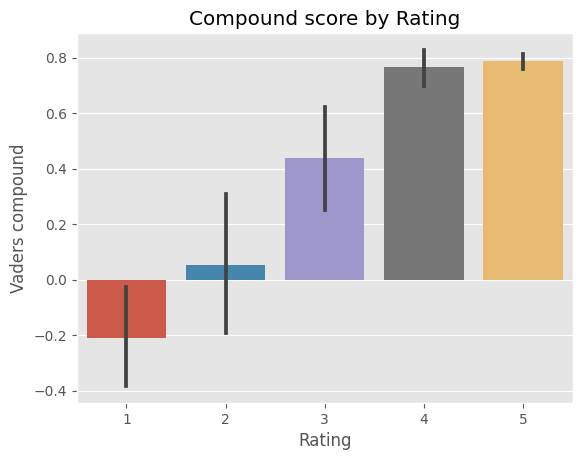

In [ ]:
ax = sns.barplot(data=vaders, x='Rating', y='Vaders compound')
ax.set_title('Compound score by Rating')
plt.show()

It is what we would expect!

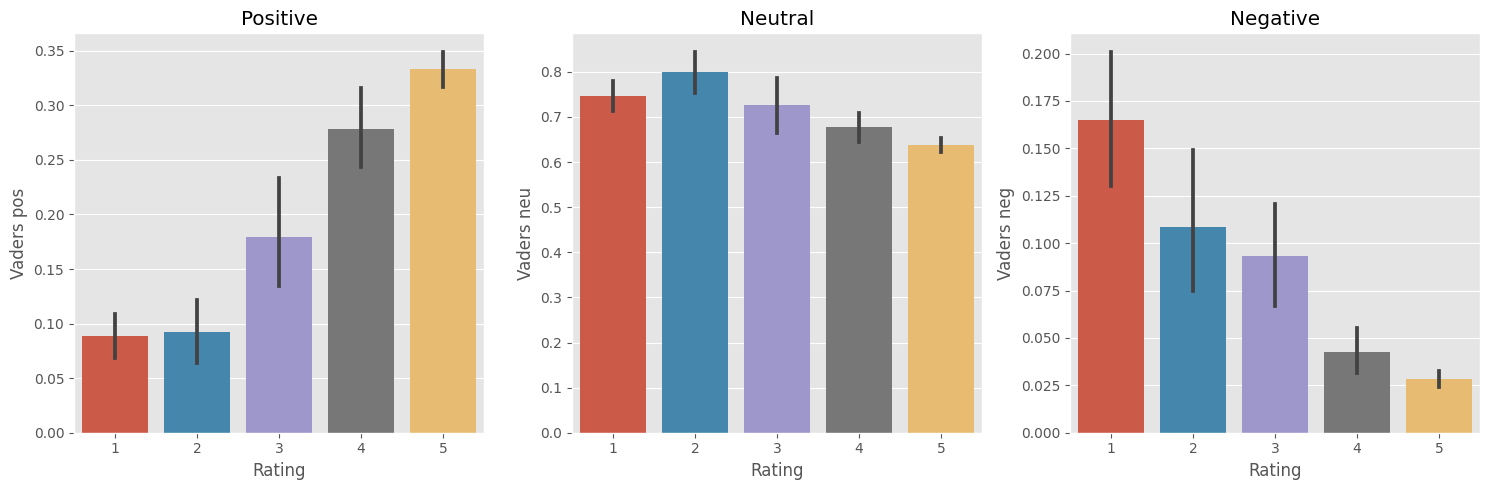

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = vaders, x='Rating', y='Vaders pos', ax = axs[0])
sns.barplot(data = vaders, x='Rating', y='Vaders neu', ax = axs[1])
sns.barplot(data = vaders, x='Rating', y='Vaders neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## RoBERTa

### The Transformers Pipeline

In [ ]:
# from transformers import pipeline

# sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline = ('phrase')